# Figure 04

$\phi$ as the measure of wether the assumptions of weak selection is fulfilled or not.
Mapping $\phi$ for a large range of parameters.

### Dimesions
#### Independent parameters
- $x = s$
- $y = U_d$
- $z = N$
#### Dependent parameter
- $\phi$

## Import libraries

In [1]:
import glob
import re
from pprint import pprint as pp

import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#import imageio

## Parameters and functions

In [2]:
def phi(
    population_size: int or float,
    selcoef: float,
    deleterious_mutation_rate: float,
    to_str: bool = True,
    strfmt: str = r".3g",
) -> str:
    """Calculate the independent lineage criterion based on Nicolaisen and
    Desai (2012).

    The independent lineage criterion, denoted as phi (φ), is used to quantify the impact of
    selection and mutation on genetic diversity in a population.

    Args:
        population_size (float): The effective population size.
        deleterious_mutation_rate (float): The rate of deleterious mutations per generation.
        selcoef (float): The selection coefficient.

    Returns:
        str: The string-formatted calculated value of the independent lineage criterion.

    Raises:
        AssertionError: If any of the input arguments are not greater than zero.

    Examples:
        >>> phi(1000, 0.01, 0.1)
        9.04837418035918

    References:
        - Nicolaisen and Desai (2012). Distortions in genealogies due to purifying selection. Mol.
          Biol. Evol. 29(11): 3589-3600
    """
    assert selcoef >= 0, "Selection coefficient must be greater (or eq) than zero."

    if selcoef > 0:
        my_phi = (
            population_size * selcoef * np.exp(-deleterious_mutation_rate / selcoef)
        )
    elif selcoef == 0:
        my_phi = 0
    else:
        assert False, "unknown selcoef, please check the code of this function"

    if to_str:
        my_phi = f"{my_phi:{strfmt}}"

    return my_phi

In [3]:
def create_custom_cmap(colors, name='custom_cmap'):
    """Create a custom colormap using LinearSegmentedColormap."""
    cmap = LinearSegmentedColormap.from_list(name, colors)
    return cmap

# Data and processing

In [4]:
# dimensions
x_num = 1024  # this is basically the resulution of the phi map figure
y_num = x_num
z_num = 20

# selection coeficient
N1 = np.array([10**(i) for i in range(13)])
N2 = np.logspace(start=np.log10(1), stop=np.log10(1_000_000_000_000), num=z_num-len(N1))
N = np.sort(np.unique(np.concatenate([N1, N2])))

s_lim = (1e-12, 1e2)
U_lim = (1e-9, 1e2)

x_id = np.arange(x_num)
y_id = np.arange(y_num)
z_id = np.arange(z_num)

s = np.logspace(start=np.log10(s_lim[0]), stop=np.log10(s_lim[1]), num=x_num)
U = np.logspace(start=np.log10(U_lim[0]), stop=np.log10(U_lim[1]), num=y_num)
z_num = len(N)
print((z_num, x_num, y_num))

(13, 1024, 1024)


In [5]:
# add some additional values manually
N = np.sort(np.concatenate((N, [500, 2e3, 5e3, 2e4])))
z_num = len(N)

In [6]:
# init phi matrix
series_N, series_s, series_U, series_phi = [], [], [], []

i = 0
for zi, xi, yi in tqdm.tqdm(np.ndindex((z_num, x_num, y_num)), total=z_num * x_num * y_num):
    series_N.append(N[zi])
    series_s.append(s[xi])
    series_U.append(U[yi])
    series_phi.append(phi(N[zi], s[xi], U[yi], to_str=False))
    i += 1

print(i)

df = pd.DataFrame(dict(
    N = series_N,
    s = series_s,
    U = series_U,
    phi = series_phi
))

100%|███████████████████████████████████████████████████████████████████| 17825792/17825792 [00:18<00:00, 946810.14it/s]


17825792


In [7]:
df.head(n=2)

,N,s,U,phi
0,1.0,1.000000e-12,1.000000e-09,0.0
1,1.0,1.000000e-12,1.025068e-09,0.0


In [8]:
df.N = df.N.apply(int)

In [9]:
df.N.unique()

array([            1,            10,           100,           500,
                1000,          2000,          5000,         10000,
               20000,        100000,       1000000,      10000000,
           100000000,    1000000000,   10000000000,  100000000000,
       1000000000000])

## Visualisation

In [21]:
def add_phi_map_by_popsize(ax, fig, popsize, df, return_pcolormesh=True, labels=(True, True)):
    assert popsize in df["N"], f"posize not found: {popsize}"

    df_filtered = df.loc[df.N == popsize]
    x = df_filtered.s.to_numpy()
    y = df_filtered.U.to_numpy()
    z = df_filtered.phi.to_numpy()

    # get x_num etc from data
    x_num = len(df_filtered.s.unique())
    y_num = len(df_filtered.U.unique())

    
    x = x.reshape((x_num, y_num))
    y = y.reshape((x_num, y_num))
    z = z.reshape((x_num, y_num))

    z[z==0] = z[z!=0].min()  # clip the zeros which represent neutrality, thus set to the minimal color value

    # make the color map being more pastel (SP preference)
    #original_cmap = plt.get_cmap("BrBG")
    #pastel_cmap = colors.ListedColormap(original_cmap(np.linspace(0.4, 0.6, 256)))
    custom_colors = [(0, '#005AB5'), (0.5, '#ffffd9'), (1, '#DC3220')]
    custom_cmap = create_custom_cmap(custom_colors)
    #custom_cmap = sns.color_palette("Spectral", as_cmap=True)
    custom_cmap = sns.color_palette("vlag_r", as_cmap=True)
    
    cmap_to_be_used = custom_cmap
        
    pc = ax.pcolormesh(
        x, y, z,
        #norm=colors.Normalize(vmin=-3, vmax=3),
        norm=colors.LogNorm(vmin=1e-2, vmax=1e2, clip=True),
        #norm=colors.SymLogNorm(linthresh=1, linscale=1,vmin=1e-1, vmax=1e1, clip=True),
        antialiased=True,
        #cmap = "PiYG",
        cmap=cmap_to_be_used
    )

    #ax.axvline(1/popsize, color="black", linewidth=1)
    #ax.axvline(100/popsize, color="black", linewidth=1)
    
    
    y_lim = ax.get_ylim()
    x_lim = ax.get_xlim()
    fill_alpha = 0.1
    #ax.fill_betweenx(y_lim, 1/popsize, 100/popsize, facecolor="gray", alpha=fill_alpha, aa=True, ec="gray")
    #ax.add_patch(patches.Rectangle((1/popsize, y_lim[0]), 100/popsize-1/popsize, y_lim[1]-y_lim[0],
    #                              edgecolor=(255/255,255/255,240/255, fill_alpha),
    #                              facecolor=(255/255,255/255,240/255, fill_alpha),
    #                              linewidth=1))
    ax.axvline(x=10/popsize, color='white', linestyle='--')
    ax.text(10/popsize * 0.625, 1.5e-5, '$N \, s = 10$',
        color="white", #"#101010",
        rotation=90)

    
    #ax.axvline(x=100/popsize, color='white', linestyle='--')
    #if not popsize == 500:  # line is absent in the smallest N
    #    ax.text(100/popsize * 0.625, 1.5e-5, '$N \, s = 100$',
    #            color="white",
    #            rotation=90)
    
    ax.set_xscale("log")
    ax.set_yscale("log")


    if labels[0]:
        ax.set_xlabel("Selection coefficient $s$")
    else:
        ax.set_xlabel("")
        ax.set_xticklabels([])
    if labels[1]:
        ax.set_ylabel("Deleterious mutation rate $U_d$")
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    
    #ax.set_title(f"$\phi (N={popsize:{r'.2g'}})$" + "\nLines show $N s=1$ and $N s=100$")
    #ax.set_title(f"$\phi (N={popsize:{r'.2g'}})$")
    ax.set_title(f"$N={int(popsize)}$")

    
    ax.set_xlim(9.5e-6, 1.5e-1)
    ax.set_ylim(9.5e-6, 2.5e-2)
    #ax.set_xticks([1e-4, 1e-3, 1e-2])

    #cb = fig.colorbar(pc, extend="both")

    if return_pcolormesh:
        return pc
    

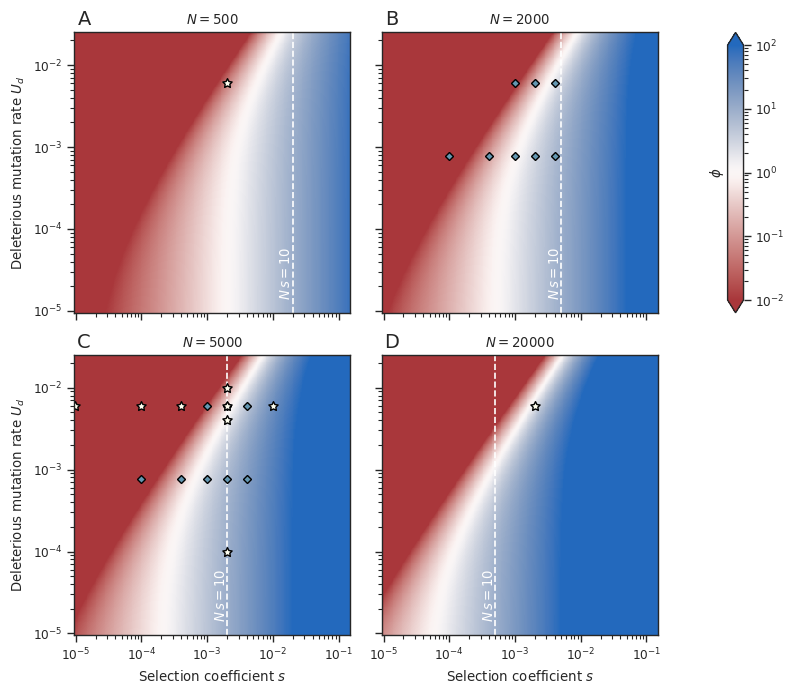

In [22]:
sns.set(style="ticks", context="paper", font_scale=1)

fig = plt.figure(figsize=(8, 7))
gs = fig.add_gridspec(nrows=2, ncols=12)
ax0 = fig.add_subplot(gs[0, 0:5])
ax1 = fig.add_subplot(gs[0, 5:10])
ax2 = fig.add_subplot(gs[1, 0:5])
ax3 = fig.add_subplot(gs[1, 5:10])
ax4 = fig.add_subplot(gs[0, 10:])

_ = add_phi_map_by_popsize(ax=ax0, fig=fig, popsize=500, df=df, labels=(False, True))
_ = add_phi_map_by_popsize(ax=ax1, fig=fig, popsize=2e3, df=df, labels=(False, False))
_ = add_phi_map_by_popsize(ax=ax2, fig=fig, popsize=5e3, df=df, labels=(True, True))
pc = add_phi_map_by_popsize(ax=ax3, fig=fig, popsize=2e4, df=df, labels=(True, False))

#_ = add_phi_map_by_popsize(ax=ax0, fig=fig, popsize=1e4, df=df, labels=(False, True))
#_ = add_phi_map_by_popsize(ax=ax1, fig=fig, popsize=1e5, df=df, labels=(False, False))
#_ = add_phi_map_by_popsize(ax=ax2, fig=fig, popsize=1e6, df=df, labels=(True, True))
#pc = add_phi_map_by_popsize(ax=ax3, fig=fig, popsize=1e7, df=df, labels=(True, False))

cb = fig.colorbar(pc, cax=ax4, extend="both")
cb.set_label('$\\phi$',
               labelpad=-55,
               #size=16
              )  # Adjust the labelpad value as needed
cb.ax.set_aspect(4)

axes = [ax0, ax1, ax2, ax3]
labels = ["A", "B", "C", "D"]
for ax_, label_ in zip(axes, labels):
    ax_.text(
        0.06, 1.08, label_,
        transform=ax_.transAxes,
        fontsize=14,
        va='top',
        ha='right'
    )
    #ax_.set_ylim(None, 1e-1)
    #ax_.set_xlim(1e-5, 2e-2)


# add simulated values
star = mpath.Path.unit_regular_star(5)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
cut_star = mpath.Path(
    vertices=np.concatenate([circle.vertices, star.vertices[::-1, ...]]),
    codes=np.concatenate([circle.codes, star.codes]))
if True:  # add values
    sim_par = dict(
        marker="D",
        markersize=4,
        fillstyle="full",
        markerfacecolor="#6497b1",
        markeredgecolor="black"
    )
    for ax_id_, ax_ in enumerate(axes):
        if ax_id_ == 2:  # N = 5000
            #ax_.plot(1e-4, 0.006, **sim_par)
            #ax_.plot(4e-4, 0.006, **sim_par)
            ax_.plot(1e-3, 0.006, **sim_par)
            ax_.plot(2e-3, 0.006, **sim_par)
            ax_.plot(4.1e-3, 0.006, **sim_par)
            ax_.plot(1e-4, 7.7e-4, **sim_par)
            ax_.plot(4e-4, 7.7e-4, **sim_par)
            ax_.plot(1e-3, 7.7e-4, **sim_par)
            ax_.plot(2e-3, 7.7e-4, **sim_par)
            ax_.plot(4.1e-3, 7.7e-4, **sim_par)
        elif ax_id_ == 1:  # N = 2000
            #ax_.plot(1e-4, 0.006, **sim_par)
            #ax_.plot(4e-4, 0.006, **sim_par)
            ax_.plot(1e-3, 0.006, **sim_par)
            ax_.plot(2e-3, 0.006, **sim_par)
            ax_.plot(4.1e-3, 0.006, **sim_par)
            ax_.plot(1e-4, 7.7e-4, **sim_par)
            ax_.plot(4e-4, 7.7e-4, **sim_par)
            ax_.plot(1e-3, 7.7e-4, **sim_par)
            ax_.plot(2e-3, 7.7e-4, **sim_par)
            ax_.plot(4.1e-3, 7.7e-4, **sim_par)


if True:  # add values
    sim_par = dict(
        marker=star,
        markersize=7,
        fillstyle="full",
        markerfacecolor="ivory",
        markeredgecolor="black"
    )
    for ax_id_, ax_ in enumerate(axes):
        if ax_id_ == 0:  # N = 500
            ax_.plot(0.002, 0.006, **sim_par)
        elif ax_id_ == 2:
            # Values Figure 5, first row
            almost_left = lambda a: np.exp((1-a)*np.log(ax_.get_xlim()[0]) + a * np.log(ax_.get_xlim()[1]))
            ax_.plot(almost_left(0.002), 0.006, **sim_par)
            ax_.plot(1e-4, 0.006, **sim_par)
            ax_.plot(4e-4, 0.006, **sim_par)
            ax_.plot(1e-2, 0.006, **sim_par)
            # Values Figure 5, second row
            ax_.plot(0.002, 1e-4, **sim_par)
            ax_.plot(0.002, 4e-3, **sim_par)
            ax_.plot(0.002, 6e-3, **sim_par)
            ax_.plot(0.002, 1e-2, **sim_par)
        elif ax_id_ == 2:
            ax_.plot(0.002, 0.006, **sim_par)
        elif ax_id_ == 3:
            ax_.plot(0.002, 0.006, **sim_par)



plt.tight_layout()

plt.show()
plt.close()

## Save data and figure

In [23]:
# get the highest version of the figure and name filename one higher
existing_versions = [int(re.search(r'v(\d+)', filename).group(1)) for filename in glob.glob("figure4_v*.png")]
if len(existing_versions):
    max_version = max(existing_versions)
else:
    max_version = 0
version = max_version + 1
assert version < 100, "Biggest version is 3 digits, you need a new string formatter"
new_filename = f"figure4_v{version:02d}.png"
print(f'Will save as "{new_filename}".')


plt.figure(fig)
plt.savefig(new_filename, dpi=600)
plt.close()
print("Done")

Will save as "figure4_v25.png".
Done
